# Video Frame Interpolation Application on Game Video with fine-tuning.

본 코드의 3, 4, 5, 6, 7, 8, 9, 14에서는 이하의 참고 코드에서 대부분 혹은 완전한 코드를 인용하였으며, 10, 13, 15에서는 참고 논문의 내용을 이용하거나, 참고 코드의 일부를 인용하여 구현하였음을 밝힙니다.

<br/>

Reference

Code: https://github.com/sniklaus/revisiting-sepconv/tree/942a018d853cfbe6510b716dd9cd10c13ec30650

Paper: https://arxiv.org/pdf/2011.01280.pdf

<br/>

본 코드와 함께 'dataset' 폴더에서 train, validation, test set을 제공하고 있으나, etl의 업로드 용량 제한 문제로 극히 일부의 데이터만 포함하고 있습니다. 따라서, 코드의 실행을 확인할 수는 있지만, 성능을 확인하기는 어려운 점을 참고해주셨으면 합니다.

실행환경은 colab이며 이외의 ipynb를 실행시킬 수 있는 환경이라면 작동 가능할 것으로 사료됩니다. 다만, requirements.txt에 있는 요구사항들이 설치되어 있어야 합니다.

또한, 구글 드라이브 연동을 수행해야 하므로 FOLDERNAME을 반드시 현 코드가 위치한 폴더로 지정하여야 정상 작동합니다.

<br/>

본 코드를 통해서 train을 해보고 싶으시다면 코드의 1~14번을 순서대로 실행하여 train 후 train된 모델을 test set에 적용하고 그 정확도를 확인할 수 있습니다. 생성된 결과물은 './image_result/test_set_train_result/' 디렉토리에 'outxxxx.png' 형태로 저장됩니다. 

<br/>

만약 best model을 테스트해보고 싶으시다면 코드의 1~12, 15를 순서대로 실행하여 test set에 대한 결과를 확인할 수 있습니다. 결과물은 './image_result/test_set_best_result/' 디렉토리에 'outxxxx.png' 형태로 저장됩니다.

이때, 테스트는 './dataset/test' 디렉토리의 이미지들에 대하여 'train_t0(i).png'와 'train_t0(i+2).png'를 입력으로 하여 'train_t0(i+1).png'의 추정 이미지를 생성합니다. (이때, 괄호는 가독성을 위해 설명에서 추가한 것이고 실제 데이터명에 괄호는 붙지 않습니다). 즉 'out(i+1).png'는 'train_t0(i+1).png'에 대한 추정 결과로 생각할 수 있으며 similarity 역시 두 이미지를 비교한 값을 사용합니다.

### 1. Mount google drive.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
# Have to target propriate folder
FOLDERNAME = '2022AI/VFI_Code'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/MyDrive/$FOLDERNAME


Mounted at /content/drive
/content/drive/MyDrive/2022AI/VFI_Code


### 2. Download necessary packages.

In [ ]:
!pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=c6b5977f036d21c74c1775ba8bf38bf6aae83cb8848974bd7689fb9fe37d5af9
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


### 3. import necessary packages.

In [ ]:
import getopt
import math
import numpy
import PIL
import PIL.Image
import sys
import torch
import typing
import time
import copy
import random
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
from sewar.full_ref import uqi

import sepconv # the custom separable convolution layer

### 4. Initial setting for torch and arguments.

In [ ]:
##########################################################

torch.set_grad_enabled(False) # make sure to not compute gradients for computational performance

torch.backends.cudnn.enabled = True # make sure to use cudnn for computational performance

##########################################################

arguments_strModel = 'paper'
arguments_strOut = './image_result/test_set_train_result/out.png'

##########################################################

### 5. class Basic.

In [ ]:
class Basic(torch.nn.Module):
    def __init__(self, strType:str, intChans:typing.List[int], objScratch:typing.Optional[typing.Dict]=None):
        super().__init__()

        self.strType = strType
        self.netEvenize = None
        self.netMain = None
        self.netShortcut = None

        intIn = intChans[0]
        intOut = intChans[-1]
        netMain = []
        intChans = intChans.copy()
        fltStride = 1.0

        for intPart, strPart in enumerate(self.strType.split('+')[0].split('-')):
            if strPart.startswith('conv') == True:
                intKsize = 3
                intPad = 1
                strPad = 'zeros'

                if '(' in strPart:
                    intKsize = int(strPart.split('(')[1].split(')')[0].split(',')[0])
                    intPad = int(math.floor(0.5 * (intKsize - 1)))

                    if 'replpad' in strPart.split('(')[1].split(')')[0].split(','): strPad = 'replicate'
                    if 'reflpad' in strPart.split('(')[1].split(')')[0].split(','): strPad = 'reflect'
                # end

                if 'nopad' in self.strType.split('+'):
                    intPad = 0
                # end

                netMain += [torch.nn.Conv2d(in_channels=intChans[0], out_channels=intChans[1], kernel_size=intKsize, stride=1, padding=intPad, padding_mode=strPad, bias='nobias' not in self.strType.split('+'))]
                intChans = intChans[1:]
                fltStride *= 1.0

            elif strPart.startswith('sconv') == True:
                intKsize = 3
                intPad = 1
                strPad = 'zeros'

                if '(' in strPart:
                    intKsize = int(strPart.split('(')[1].split(')')[0].split(',')[0])
                    intPad = int(math.floor(0.5 * (intKsize - 1)))

                    if 'replpad' in strPart.split('(')[1].split(')')[0].split(','): strPad = 'replicate'
                    if 'reflpad' in strPart.split('(')[1].split(')')[0].split(','): strPad = 'reflect'
                # end

                if 'nopad' in self.strType.split('+'):
                    intPad = 0
                # end

                netMain += [torch.nn.Conv2d(in_channels=intChans[0], out_channels=intChans[1], kernel_size=intKsize, stride=2, padding=intPad, padding_mode=strPad, bias='nobias' not in self.strType.split('+'))]
                intChans = intChans[1:]
                fltStride *= 2.0

            elif strPart.startswith('up') == True:
                class Up(torch.nn.Module):
                    def __init__(self, strType):
                        super().__init__()

                        self.strType = strType
                    # end

                    def forward(self, tenIn:torch.Tensor) -> torch.Tensor:
                        if self.strType == 'nearest':
                            return torch.nn.functional.interpolate(input=tenIn, scale_factor=2.0, mode='nearest-exact', align_corners=False)

                        elif self.strType == 'bilinear':
                            return torch.nn.functional.interpolate(input=tenIn, scale_factor=2.0, mode='bilinear', align_corners=False)

                        elif self.strType == 'pyramid':
                            return pyramid(tenIn, None, 'up')

                        elif self.strType == 'shuffle':
                            return torch.nn.functional.pixel_shuffle(tenIn, upscale_factor=2) # https://github.com/pytorch/pytorch/issues/62854

                        # end

                        assert(False) # to make torchscript happy
                    # end
                # end

                strType = 'bilinear'

                if '(' in strPart:
                    if 'nearest' in strPart.split('(')[1].split(')')[0].split(','): strType = 'nearest'
                    if 'pyramid' in strPart.split('(')[1].split(')')[0].split(','): strType = 'pyramid'
                    if 'shuffle' in strPart.split('(')[1].split(')')[0].split(','): strType = 'shuffle'
                # end

                netMain += [Up(strType)]
                fltStride *= 0.5

            elif strPart.startswith('prelu') == True:
                netMain += [torch.nn.PReLU(num_parameters=1, init=float(strPart.split('(')[1].split(')')[0].split(',')[0]))]
                fltStride *= 1.0

            elif True:
                assert(False)

            # end
        # end

        self.netMain = torch.nn.Sequential(*netMain)

        for strPart in self.strType.split('+')[1:]:
            if strPart.startswith('skip') == True:
                if intIn == intOut and fltStride == 1.0:
                    self.netShortcut = torch.nn.Identity()

                elif intIn != intOut and fltStride == 1.0:
                    self.netShortcut = torch.nn.Conv2d(in_channels=intIn, out_channels=intOut, kernel_size=1, stride=1, padding=0, bias='nobias' not in self.strType.split('+'))

                elif intIn == intOut and fltStride != 1.0:
                    class Down(torch.nn.Module):
                        def __init__(self, fltScale):
                            super().__init__()

                            self.fltScale = fltScale
                        # end

                        def forward(self, tenIn:torch.Tensor) -> torch.Tensor:
                            return torch.nn.functional.interpolate(input=tenIn, scale_factor=self.fltScale, mode='bilinear', align_corners=False)
                        # end
                    # end

                    self.netShortcut = Down(1.0 / fltStride)

                elif intIn != intOut and fltStride != 1.0:
                    class Down(torch.nn.Module):
                        def __init__(self, fltScale):
                            super().__init__()

                            self.fltScale = fltScale
                        # end

                        def forward(self, tenIn:torch.Tensor) -> torch.Tensor:
                            return torch.nn.functional.interpolate(input=tenIn, scale_factor=self.fltScale, mode='bilinear', align_corners=False)
                        # end
                    # end

                    self.netShortcut = torch.nn.Sequential(Down(1.0 / fltStride), torch.nn.Conv2d(in_channels=intIn, out_channels=intOut, kernel_size=1, stride=1, padding=0, bias='nobias' not in self.strType.split('+')))

                # end

            elif strPart.startswith('...') == True:
                pass

            # end
        # end

        assert(len(intChans) == 1)
    # end

    def forward(self, tenIn:torch.Tensor) -> torch.Tensor:
        if self.netEvenize is not None:
            tenIn = self.netEvenize(tenIn)
        # end

        tenOut = self.netMain(tenIn)

        if self.netShortcut is not None:
            tenOut = tenOut + self.netShortcut(tenIn)
        # end

        return tenOut
    # end
# end

### 6. class Encode.

In [ ]:
class Encode(torch.nn.Module):
    objScratch:typing.Dict[str, typing.List[int]] = None

    def __init__(self, intIns:typing.List[int], intOuts:typing.List[int], strHor:str, strVer:str, objScratch:typing.Dict[str, typing.List[int]]):
        super().__init__()

        assert(len(intIns) == len(intOuts))
        assert(len(intOuts) == len(intIns))

        self.intRows = len(intIns) and len(intOuts)
        self.intIns = intIns.copy()
        self.intOuts = intOuts.copy()
        self.strHor = strHor
        self.strVer = strVer
        self.objScratch = objScratch

        self.netHor = torch.nn.ModuleList()
        self.netVer = torch.nn.ModuleList()

        for intRow in range(self.intRows):
            netHor = torch.nn.Identity()
            netVer = torch.nn.Identity()

            if self.intOuts[intRow] != 0:
                if self.intIns[intRow] != 0:
                    netHor = Basic(self.strHor, [self.intIns[intRow], self.intOuts[intRow], self.intOuts[intRow]], objScratch)
                # end

                if intRow != 0:
                    netVer = Basic(self.strVer, [self.intOuts[intRow - 1], self.intOuts[intRow], self.intOuts[intRow]], objScratch)
                # end
            # end

            self.netHor.append(netHor)
            self.netVer.append(netVer)
        # end
    # end

    def forward(self, tenIns:typing.List[torch.Tensor]) -> typing.List[torch.Tensor]:
        intRow = 0
        for netHor in self.netHor:
            if self.intOuts[intRow] != 0:
                if self.intIns[intRow] != 0:
                    tenIns[intRow] = netHor(tenIns[intRow])
                # end
            # end
            intRow += 1
        # end

        intRow = 0
        for netVer in self.netVer:
            if self.intOuts[intRow] != 0:
                if intRow != 0:
                    tenIns[intRow] = tenIns[intRow] + netVer(tenIns[intRow - 1])
                # end
            # end
            intRow += 1
        # end

        for intRow, tenIn in enumerate(tenIns):
            self.objScratch['levelshape' + str(intRow)] = tenIn.shape
        # end

        return tenIns
    # end
# end

###  7. class Decode

In [ ]:
class Decode(torch.nn.Module):
    objScratch:typing.Dict[str, typing.List[int]] = None

    def __init__(self, intIns:typing.List[int], intOuts:typing.List[int], strHor:str, strVer:str, objScratch:typing.Dict[str, typing.List[int]]):
        super().__init__()

        assert(len(intIns) == len(intOuts))
        assert(len(intOuts) == len(intIns))

        self.intRows = len(intIns) and len(intOuts)
        self.intIns = intIns.copy()
        self.intOuts = intOuts.copy()
        self.strHor = strHor
        self.strVer = strVer
        self.objScratch = objScratch

        self.netHor = torch.nn.ModuleList()
        self.netVer = torch.nn.ModuleList()

        for intRow in range(self.intRows - 1, -1, -1):
            netHor = torch.nn.Identity()
            netVer = torch.nn.Identity()

            if self.intOuts[intRow] != 0:
                if self.intIns[intRow] != 0:
                    netHor = Basic(self.strHor, [self.intIns[intRow], self.intOuts[intRow], self.intOuts[intRow]], objScratch)
                # end

                if intRow != self.intRows - 1:
                    netVer = Basic(self.strVer, [self.intOuts[intRow + 1], self.intOuts[intRow], self.intOuts[intRow]], objScratch)
                # end
            # end

            self.netHor.append(netHor)
            self.netVer.append(netVer)
        # end
    # end

    def forward(self, tenIns:typing.List[torch.Tensor]) -> typing.List[torch.Tensor]:
        intRow = self.intRows - 1
        for netHor in self.netHor:
            if self.intOuts[intRow] != 0:
                if self.intIns[intRow] != 0:
                    tenIns[intRow] = netHor(tenIns[intRow])
                # end
            # end
            intRow -= 1
        # end

        intRow = self.intRows - 1
        for netVer in self.netVer:
            if self.intOuts[intRow] != 0:
                if intRow != self.intRows - 1:
                    tenVer = netVer(tenIns[intRow + 1])

                    if 'levelshape' + str(intRow) in self.objScratch:
                        if tenVer.shape[2] == self.objScratch['levelshape' + str(intRow)][2] + 1: tenVer = torch.nn.functional.pad(input=tenVer, pad=[0, 0, 0, -1], mode='constant', value=0.0)
                        if tenVer.shape[3] == self.objScratch['levelshape' + str(intRow)][3] + 1: tenVer = torch.nn.functional.pad(input=tenVer, pad=[0, -1, 0, 0], mode='constant', value=0.0)
                    # end

                    tenIns[intRow] = tenIns[intRow] + tenVer
                # end
            # end
            intRow -= 1
        # end

        return tenIns
    # end
# end

### 8. class Network.

In [ ]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.intEncdec = [1, 1]
        self.intChannels = [32, 64, 128, 256, 512]

        self.objScratch = {}

        self.netInput = torch.nn.Conv2d(in_channels=3, out_channels=int(round(0.5 * self.intChannels[0])), kernel_size=3, stride=1, padding=1, padding_mode='zeros')

        self.netEncode = torch.nn.Sequential(*(
            [Encode([0] * len(self.intChannels), self.intChannels, 'prelu(0.25)-conv(3)-prelu(0.25)-conv(3)+skip', 'prelu(0.25)-sconv(3)-prelu(0.25)-conv(3)', self.objScratch)] +
            [Encode(self.intChannels, self.intChannels, 'prelu(0.25)-conv(3)-prelu(0.25)-conv(3)+skip', 'prelu(0.25)-sconv(3)-prelu(0.25)-conv(3)', self.objScratch) for intEncdec in range(1, self.intEncdec[0])]
        ))

        self.netDecode = torch.nn.Sequential(*(
            [Decode([0] + self.intChannels[1:], [0] + self.intChannels[1:], 'prelu(0.25)-conv(3)-prelu(0.25)-conv(3)+skip', 'prelu(0.25)-up(bilinear)-conv(3)-prelu(0.25)-conv(3)', self.objScratch) for intEncdec in range(0, self.intEncdec[1])]
        ))

        self.netVerone = Basic('up(bilinear)-conv(3)-prelu(0.25)-conv(3)', [self.intChannels[1], self.intChannels[1], 51])
        self.netVertwo = Basic('up(bilinear)-conv(3)-prelu(0.25)-conv(3)', [self.intChannels[1], self.intChannels[1], 51])
        self.netHorone = Basic('up(bilinear)-conv(3)-prelu(0.25)-conv(3)', [self.intChannels[1], self.intChannels[1], 51])
        self.netHortwo = Basic('up(bilinear)-conv(3)-prelu(0.25)-conv(3)', [self.intChannels[1], self.intChannels[1], 51])

        self.load_state_dict(torch.hub.load_state_dict_from_url(url='http://content.sniklaus.com/resepconv/network-' + arguments_strModel + '.pytorch', file_name='resepconv-' + arguments_strModel))
    # end

    def forward(self, tenSeq):
        assert(len(tenSeq) == 2)

        tenOne = tenSeq[0]
        tenTwo = tenSeq[1]

        with torch.set_grad_enabled(False):
            tenStack = torch.stack(tenSeq, 1)
            tenMean = tenStack.view(tenStack.shape[0], -1).mean(1, True).view(tenStack.shape[0], 1, 1, 1)
            tenStd = tenStack.view(tenStack.shape[0], -1).std(1, True).view(tenStack.shape[0], 1, 1, 1)
            tenSeq = [(tenFrame - tenMean) / (tenStd + 0.0000001) for tenFrame in tenSeq]
            tenSeq = [tenFrame.detach() for tenFrame in tenSeq]
        # end

        tenOut = self.netDecode(self.netEncode([torch.cat([self.netInput(tenSeq[0]), self.netInput(tenSeq[1])], 1)] + ([0.0] * (len(self.intChannels) - 1))))[1]

        tenOne = torch.nn.functional.pad(input=tenOne, pad=[int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51))], mode='replicate')
        tenTwo = torch.nn.functional.pad(input=tenTwo, pad=[int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51))], mode='replicate')

        tenOne = torch.cat([tenOne, tenOne.new_ones([tenOne.shape[0], 1, tenOne.shape[2], tenOne.shape[3]])], 1).detach()
        tenTwo = torch.cat([tenTwo, tenTwo.new_ones([tenTwo.shape[0], 1, tenTwo.shape[2], tenTwo.shape[3]])], 1).detach()

        tenVerone = self.netVerone(tenOut)
        tenVertwo = self.netVertwo(tenOut)
        tenHorone = self.netHorone(tenOut)
        tenHortwo = self.netHortwo(tenOut)

        tenOut = sepconv.sepconv_func.apply(tenOne, tenVerone, tenHorone) + sepconv.sepconv_func.apply(tenTwo, tenVertwo, tenHortwo)

        tenNormalize = tenOut[:, -1:, :, :]
        tenNormalize[tenNormalize.abs() < 0.01] = 1.0
        tenOut = tenOut[:, :-1, :, :] / tenNormalize

        return tenOut
    # end
# end

netNetwork = Network().cuda().eval()

Downloading: "http://content.sniklaus.com/resepconv/network-paper.pytorch" to /root/.cache/torch/hub/checkpoints/resepconv-paper


  0%|          | 0.00/51.8M [00:00<?, ?B/s]

### 9. estimate - get two frame as tensor and generate output frame with model.

In [ ]:
def estimate(tenOne, tenTwo):

    assert(tenOne.shape[1] == tenTwo.shape[1])
    assert(tenOne.shape[2] == tenTwo.shape[2])

    intWidth = tenOne.shape[2]
    intHeight = tenOne.shape[1]

    assert(intWidth <= 1280) # while our approach works with larger images, we do not recommend it unless you are aware of the implications
    assert(intHeight <= 720) # while our approach works with larger images, we do not recommend it unless you are aware of the implications

    tenPreprocessedOne = tenOne.cuda().view(1, 3, intHeight, intWidth)
    tenPreprocessedTwo = tenTwo.cuda().view(1, 3, intHeight, intWidth)

    intPadr = (2 - (intWidth % 2)) % 2
    intPadb = (2 - (intHeight % 2)) % 2

    tenPreprocessedOne = torch.nn.functional.pad(input=tenPreprocessedOne, pad=[0, intPadr, 0, intPadb], mode='replicate')
    tenPreprocessedTwo = torch.nn.functional.pad(input=tenPreprocessedTwo, pad=[0, intPadr, 0, intPadb], mode='replicate')

    return netNetwork([tenPreprocessedOne, tenPreprocessedTwo])[0, :, :intHeight, :intWidth].cpu()
# end

### 10. Loss function

In [ ]:
from torchvision.models import vgg16_bn

# load VGG16 pre-trained model
vgg_m = vgg16_bn(True).features.cuda().eval()
vgg_m.requires_grad = False

# get features with pre-trained VGG model
def get_features(x, model, f_layer):
    for name, layer in enumerate(model.children()): 
        x = layer(x)
        if(name == f_layer):
            break
    return x

# L2 loss with VGG perceptual loss
def image_loss_with_vgg(image_out, image_gt):    
    # preprocess image to get features     
    intWidth = image_gt.shape[2]
    intHeight = image_gt.shape[1]
    tenPreprocessedOut = image_out.cuda().view(1, 3, intHeight, intWidth)
    tenPreprocessedGt = image_gt.cuda().view(1, 3, intHeight, intWidth)
    intPadr = (2 - (intWidth % 2)) % 2
    intPadb = (2 - (intHeight % 2)) % 2
    tenPreprocessedGt = torch.nn.functional.pad(input=tenPreprocessedGt, pad=[0, intPadr, 0, intPadb], mode='replicate')

    # get features with VGG pre-trained model
    out_features = get_features(tenPreprocessedOut, vgg_m, 5)
    gt_features = get_features(tenPreprocessedGt, vgg_m, 5)

    feature_loss = torch.sum(torch.square(out_features - gt_features))
    return feature_loss

# combination L1 loss with VGG perceptual loss (Used in our paper)
def image_loss_with_vgg2(image_out, image_gt, alpha=0.2, beta=0.01):    
    # preprocess image to get features     
    intWidth = image_gt.shape[2]
    intHeight = image_gt.shape[1]
    tenPreprocessedOut = image_out.cuda().view(1, 3, intHeight, intWidth)
    tenPreprocessedGt = image_gt.cuda().view(1, 3, intHeight, intWidth)
    intPadr = (2 - (intWidth % 2)) % 2
    intPadb = (2 - (intHeight % 2)) % 2
    tenPreprocessedGt = torch.nn.functional.pad(input=tenPreprocessedGt, pad=[0, intPadr, 0, intPadb], mode='replicate')

    # get features with VGG pre-trained model
    out_features = get_features(tenPreprocessedOut, vgg_m, 5)
    gt_features = get_features(tenPreprocessedGt, vgg_m, 5)

    feature_loss = beta*torch.sum(torch.abs(image_out - image_gt)) + alpha*torch.sum(torch.abs(out_features-gt_features))
    return feature_loss

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### 11. UQI wrapper - UQI(Universal Quality Image Index, a kind of image similarity measurement)

In [ ]:
def uqi_wrapper(out_image, image_gt):
    out_image_in_nparray = out_image.clip(0.0, 1.0).numpy().transpose(1, 2, 0)[:, :, ::-1]
    image_gt_in_nparray = image_gt.clip(0.0, 1.0).numpy().transpose(1, 2, 0)[:, :, ::-1]
    return uqi(out_image_in_nparray, image_gt_in_nparray)

### 12. Load Dataset.

In [ ]:
dataset = None
# train:val = 5:1 in paper setting, reduced in here because of etl capacity limitation.
# type of each contructed data - [image1, image_gt, image2]
train_size = 22
valid_size = 20
train_start_index = 200
valid_start_index = [600, 720, 840, 960]
train_set_prefix = './dataset/train/train_t0'
valid_set_prefix = './dataset/val/train_t0'

# loaded images
train_images = []
valid_images = []

# contructed data set
train_set = []
valid_set = []

for i in range(train_size):
    # load train image as tensor
    train_image = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(train_set_prefix + str(train_start_index+i+1).zfill(4) + '.png'))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))
    train_images.append(train_image)

for i in range(train_size-2):
    # construct train set
    train_set.append([train_images[i], train_images[i+1], train_images[i+2]])

for k in range(4):
    valid_image = []
    for i in range(int(valid_size/4)):
        # load validation image as tensor
        valid_image = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(valid_set_prefix + str(valid_start_index[k]+i+1).zfill(4) + '.png'))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))
        valid_images.append(valid_image)

    for i in range(int(valid_size/4)-2):
        # construct validation set
        valid_set.append([valid_images[i],valid_images[i+1], valid_images[i+2]])

# shuffle train set
random.shuffle(train_set)
dataset = {'train':train_set, 'val':valid_set}

### 13. Fine-Tuning
Fine-Tuning for game framges. 

Reference: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

Epoch 1/12
train Loss: 955.3316	Similarity: 99.53%
val Loss: 972.4583	Similarity: 98.93%

Epoch 2/12
train Loss: 912.9163	Similarity: 99.55%
val Loss: 971.9485	Similarity: 98.95%

Epoch 3/12
train Loss: 952.6818	Similarity: 99.52%
val Loss: 988.5024	Similarity: 98.82%

Epoch 4/12
train Loss: 961.5461	Similarity: 99.58%
val Loss: 976.2003	Similarity: 98.86%

Epoch 5/12
train Loss: 929.0317	Similarity: 99.62%
val Loss: 970.1550	Similarity: 98.89%

Epoch 6/12
train Loss: 945.3209	Similarity: 99.45%
val Loss: 977.9362	Similarity: 98.92%

Epoch 7/12
train Loss: 901.4603	Similarity: 99.64%
val Loss: 964.3447	Similarity: 98.92%

Epoch 8/12
train Loss: 914.5956	Similarity: 99.52%
val Loss: 962.1952	Similarity: 98.93%

Epoch 9/12
train Loss: 895.1530	Similarity: 99.60%
val Loss: 962.5142	Similarity: 98.94%

Epoch 10/12
train Loss: 919.4625	Similarity: 99.53%
val Loss: 960.1688	Similarity: 98.95%

Epoch 11/12
train Loss: 905.3698	Similarity: 99.58%
val Loss: 956.9116	Similarity: 98.98%

Epoch 12

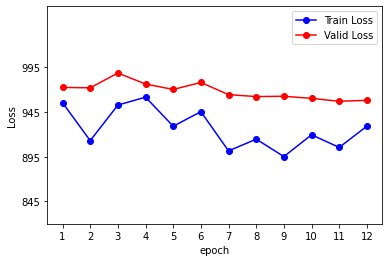

In [ ]:
# image preprocessing
def preprocess_image(image1, image2):
    # image size equality check
    assert(image1.shape[1] == image2.shape[1])
    assert(image1.shape[2] == image2.shape[2])

    intWidth = image1.shape[2]
    intHeight = image1.shape[1]

    # image size limit check
    assert(intWidth <= 1280)
    assert(intHeight <= 720)

    image1_preprocessed = image1.cuda().view(1, 3, intHeight, intWidth)
    image2_preprocessed = image2.cuda().view(1, 3, intHeight, intWidth)

    intPadr = (2 - (intWidth % 2)) % 2
    intPadb = (2 - (intHeight % 2)) % 2

    image1_preprocessed = torch.nn.functional.pad(input=image1_preprocessed, pad=[0, intPadr, 0, intPadb], mode='replicate')
    image2_preprocessed = torch.nn.functional.pad(input=image2_preprocessed, pad=[0, intPadr, 0, intPadb], mode='replicate')
    return intWidth, intHeight, image1_preprocessed, image2_preprocessed

# train for game images
def train_vfi(model, optimizer, scheduler, num_epochs = 20, batch_size = 5):
    start = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_similarity = 0.0
    train_losses = []
    valid_losses = []
    train_size_in_batch = train_size-2
    valid_size_in_batch = valid_size-8

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        if epoch % (int(train_size_in_batch / batch_size)) == 0:
            random.shuffle(dataset['train'])

        for phase in ['train', 'val']:
            if phase == 'train':
                # model to train mode
                model.train()
            else:
                # model to evaluation mode
                model.eval()
            
            total_loss = 0.0
            total_similarity = 0.0

            curr_dataset = None
            if phase == 'train':
                batch_start_index = (epoch*batch_size) % train_size_in_batch

                curr_dataset = dataset[phase][batch_start_index:batch_start_index + batch_size]
            else:
                curr_dataset = dataset[phase]

            for image1, image_gt, image2 in curr_dataset:
                image1 = image1.cuda()
                image2 = image2.cuda()
                image_gt = image_gt.cuda()

                optimizer.zero_grad()

                # foward
                with torch.set_grad_enabled(phase == 'train'):
                    width, height, image1_p, image2_p = preprocess_image(image1, image2)
                    out_image = model([image1_p, image2_p])[0, :, :height, :width]
                    loss = image_loss_with_vgg2(out_image, image_gt)
                    sim = uqi_wrapper(torch.clone(out_image).cpu().detach(), torch.clone(image_gt).cpu().detach())

                    # backpropagation in train mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                total_loss += loss
                total_similarity += sim
            
            if phase == 'train':
                scheduler.step()

            dataset_size = 1
            if phase == 'train':
                dataset_size = batch_size
            else:
                dataset_size = valid_size_in_batch

            # caculate epoch loss and similarity
            epoch_loss = total_loss / dataset_size
            epoch_sim = total_similarity / dataset_size

            if phase == 'train':
                train_losses.append(epoch_loss.cpu())
            else:
                valid_losses.append(epoch_loss.cpu())

            print(f'{phase} Loss: {epoch_loss:.4f}\tSimilarity: {epoch_sim * 100:.2f}%')

            # deep copy the better model
            if phase == 'val' and epoch_sim > best_similarity:
                best_similarity = epoch_sim
                best_model = copy.deepcopy(model.state_dict())
        print()


    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_similarity:4f}')

    # plot train and valid loss
    xt = numpy.arange(1, num_epochs+1, 1)
    mint = min(int(min(train_losses)), int(min(valid_losses)))
    maxt = max(int(max(train_losses)), int(max(valid_losses)))
    plt.plot(xt, train_losses, '-bo', label='Train Loss')
    plt.plot(xt, valid_losses, '-ro', label='Valid Loss')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim(int(min(train_losses))-75, int(max(valid_losses))+75)
    plt.xticks(xt)
    plt.yticks(numpy.arange(int(min(train_losses))-50, int(max(valid_losses))+50, 50))
    plt.legend()

    # load the best model weights
    model.load_state_dict(best_model)
    return model

# train!
optimizer = optim.Adamax(netNetwork.parameters(), lr=0.0005, betas=(0.9, 0.999))
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)
best_model = train_vfi(netNetwork, optimizer, scheduler, 12)

### 14. RUN!

In [ ]:
arguments_strOne = './dataset/val/'
arguments_strTwo = './dataset/val/'
arguments_strMultih = './dataset/test/train_t0'

multi_image = True
image_len = 50
image_start = 751
test_set_similarity = 0.0

if arguments_strOut.split('.')[-1] in ['bmp', 'jpg', 'jpeg', 'png']:
    if multi_image:
        for i in range(image_start, image_start+image_len-2):
            tenOne = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strMultih + str(i).zfill(4) + '.png'))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))
            tenTwo = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strMultih + str(i+2).zfill(4) + '.png'))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))

            tenOutput = estimate(tenOne, tenTwo)
            tenGt = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strMultih + str(i+1).zfill(4) + '.png'))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))
            test_set_similarity += uqi_wrapper(torch.clone(tenOutput).cpu().detach(), torch.clone(tenGt).cpu().detach())

            PIL.Image.fromarray((tenOutput.clip(0.0, 1.0).numpy().transpose(1, 2, 0)[:, :, ::-1] * 255.0).astype(numpy.uint8)).save(arguments_strOut[:len(arguments_strOut)-4] + str(i+1).zfill(4) + '.png')
        
        print(f'test Acc: {test_set_similarity / image_len * 100:3f} %')


    else:
        ## generate just one frame from two images
        tenOne = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strOne))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))
        tenTwo = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strTwo))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))

        tenOutput = estimate(tenOne, tenTwo)
        PIL.Image.fromarray((tenOutput.clip(0.0, 1.0).numpy().transpose(1, 2, 0)[:, :, ::-1] * 255.0).astype(numpy.uint8)).save(arguments_strOut)
# end

test Acc: 98.907164 %


### 15. Load best model and run for test set.

In [ ]:
# Same with original Network class but load model from './best_weights/best_model_state_dict.pt'
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.intEncdec = [1, 1]
        self.intChannels = [32, 64, 128, 256, 512]

        self.objScratch = {}

        self.netInput = torch.nn.Conv2d(in_channels=3, out_channels=int(round(0.5 * self.intChannels[0])), kernel_size=3, stride=1, padding=1, padding_mode='zeros')

        self.netEncode = torch.nn.Sequential(*(
            [Encode([0] * len(self.intChannels), self.intChannels, 'prelu(0.25)-conv(3)-prelu(0.25)-conv(3)+skip', 'prelu(0.25)-sconv(3)-prelu(0.25)-conv(3)', self.objScratch)] +
            [Encode(self.intChannels, self.intChannels, 'prelu(0.25)-conv(3)-prelu(0.25)-conv(3)+skip', 'prelu(0.25)-sconv(3)-prelu(0.25)-conv(3)', self.objScratch) for intEncdec in range(1, self.intEncdec[0])]
        ))

        self.netDecode = torch.nn.Sequential(*(
            [Decode([0] + self.intChannels[1:], [0] + self.intChannels[1:], 'prelu(0.25)-conv(3)-prelu(0.25)-conv(3)+skip', 'prelu(0.25)-up(bilinear)-conv(3)-prelu(0.25)-conv(3)', self.objScratch) for intEncdec in range(0, self.intEncdec[1])]
        ))

        self.netVerone = Basic('up(bilinear)-conv(3)-prelu(0.25)-conv(3)', [self.intChannels[1], self.intChannels[1], 51])
        self.netVertwo = Basic('up(bilinear)-conv(3)-prelu(0.25)-conv(3)', [self.intChannels[1], self.intChannels[1], 51])
        self.netHorone = Basic('up(bilinear)-conv(3)-prelu(0.25)-conv(3)', [self.intChannels[1], self.intChannels[1], 51])
        self.netHortwo = Basic('up(bilinear)-conv(3)-prelu(0.25)-conv(3)', [self.intChannels[1], self.intChannels[1], 51])

        self.load_state_dict(torch.load('./best_weights/best_model_state_dict.pt'))
    # end

    def forward(self, tenSeq):
        assert(len(tenSeq) == 2)

        tenOne = tenSeq[0]
        tenTwo = tenSeq[1]

        with torch.set_grad_enabled(False):
            tenStack = torch.stack(tenSeq, 1)
            tenMean = tenStack.view(tenStack.shape[0], -1).mean(1, True).view(tenStack.shape[0], 1, 1, 1)
            tenStd = tenStack.view(tenStack.shape[0], -1).std(1, True).view(tenStack.shape[0], 1, 1, 1)
            tenSeq = [(tenFrame - tenMean) / (tenStd + 0.0000001) for tenFrame in tenSeq]
            tenSeq = [tenFrame.detach() for tenFrame in tenSeq]
        # end

        tenOut = self.netDecode(self.netEncode([torch.cat([self.netInput(tenSeq[0]), self.netInput(tenSeq[1])], 1)] + ([0.0] * (len(self.intChannels) - 1))))[1]

        tenOne = torch.nn.functional.pad(input=tenOne, pad=[int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51))], mode='replicate')
        tenTwo = torch.nn.functional.pad(input=tenTwo, pad=[int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51)), int(math.floor(0.5 * 51))], mode='replicate')

        tenOne = torch.cat([tenOne, tenOne.new_ones([tenOne.shape[0], 1, tenOne.shape[2], tenOne.shape[3]])], 1).detach()
        tenTwo = torch.cat([tenTwo, tenTwo.new_ones([tenTwo.shape[0], 1, tenTwo.shape[2], tenTwo.shape[3]])], 1).detach()

        tenVerone = self.netVerone(tenOut)
        tenVertwo = self.netVertwo(tenOut)
        tenHorone = self.netHorone(tenOut)
        tenHortwo = self.netHortwo(tenOut)

        tenOut = sepconv.sepconv_func.apply(tenOne, tenVerone, tenHorone) + sepconv.sepconv_func.apply(tenTwo, tenVertwo, tenHortwo)

        tenNormalize = tenOut[:, -1:, :, :]
        tenNormalize[tenNormalize.abs() < 0.01] = 1.0
        tenOut = tenOut[:, :-1, :, :] / tenNormalize

        return tenOut
    # end
# end

best_model = Network().cuda().eval()

In [ ]:
# Run for best model
arguments_strMultih = './dataset/test/train_t0'
arguments_strOut = './image_result/test_set_best_result/out.png'

image_len = 50
image_start = 751
test_set_similarity = 0.0

# estimate intermediate frame with best model
def estimate_on_best_model(tenOne, tenTwo):

    assert(tenOne.shape[1] == tenTwo.shape[1])
    assert(tenOne.shape[2] == tenTwo.shape[2])

    intWidth = tenOne.shape[2]
    intHeight = tenOne.shape[1]

    assert(intWidth <= 1280) # while our approach works with larger images, we do not recommend it unless you are aware of the implications
    assert(intHeight <= 720) # while our approach works with larger images, we do not recommend it unless you are aware of the implications

    tenPreprocessedOne = tenOne.cuda().view(1, 3, intHeight, intWidth)
    tenPreprocessedTwo = tenTwo.cuda().view(1, 3, intHeight, intWidth)

    intPadr = (2 - (intWidth % 2)) % 2
    intPadb = (2 - (intHeight % 2)) % 2

    tenPreprocessedOne = torch.nn.functional.pad(input=tenPreprocessedOne, pad=[0, intPadr, 0, intPadb], mode='replicate')
    tenPreprocessedTwo = torch.nn.functional.pad(input=tenPreprocessedTwo, pad=[0, intPadr, 0, intPadb], mode='replicate')

    return best_model([tenPreprocessedOne, tenPreprocessedTwo])[0, :, :intHeight, :intWidth].cpu()
# end

for i in range(image_start, image_start+image_len-2):
    # input frame is ith and (i+2)th frame
    tenOne = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strMultih + str(i).zfill(4) + '.png'))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))
    tenTwo = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strMultih + str(i+2).zfill(4) + '.png'))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))

    tenOutput = estimate_on_best_model(tenOne, tenTwo)
    # result fram is (i+1)th frame
    tenGt = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(PIL.Image.open(arguments_strMultih + str(i+1).zfill(4) + '.png'))[:, :, ::-1].transpose(2, 0, 1).astype(numpy.float32) * (1.0 / 255.0)))
    test_set_similarity += uqi_wrapper(torch.clone(tenOutput).cpu().detach(), torch.clone(tenGt).cpu().detach())

    PIL.Image.fromarray((tenOutput.clip(0.0, 1.0).numpy().transpose(1, 2, 0)[:, :, ::-1] * 255.0).astype(numpy.uint8)).save(arguments_strOut[:len(arguments_strOut)-4] + str(i+1).zfill(4) + '.png')

# print accuracy for test set
print(f'test Acc: {test_set_similarity / image_len * 100:3f} %')

test Acc: 98.907164 %
